# [Домашнє завдання до модуля «Алгоритми навчання з вчителем Ч.3»](https://www.edu.goit.global/uk/learn/25315460/23598278/25274059/homework)
___

## Імпорт необхідних модулів

In [1]:
import datetime

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             r2_score)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

## 1. Завантаження даних

[Logistic Regression Tutorial CSEC](https://www.kaggle.com/code/samuelkeno/logistic-regression-tutorial-csec#Logistic-Regression)

In [2]:
TARGET = "Salary"
train_data = pd.read_csv("../datasets/mod_04_hw_train_data.csv")
valid_data = pd.read_csv("../datasets/mod_04_hw_valid_data.csv")

In [3]:
print(f"Training data shape: {train_data.shape}")
display(train_data.head())
print(f"Validation data shape: {valid_data.shape}")
display(valid_data.head())

Training data shape: (249, 9)


,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Jennifer Hernandez,120-602-1220,3.0,Msc,Tier2,Mid,Yes,25/08/1972,98000
1,Timothy Walker,840-675-8650,5.0,PhD,Tier2,Senior,Yes,03/12/2013,135500
2,David Duran,556-293-8643,5.0,Msc,Tier2,Senior,Yes,19/07/2002,123500
3,Gloria Ortega,463-559-7474,3.0,Bsc,Tier3,Mid,No,19/02/1970,85000
4,Matthew Steele,968-091-7683,5.0,Bsc,Tier2,Senior,Yes,20/02/1970,111500


Validation data shape: (7, 9)


,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Alvaro Johnson,320-636-8883,7,Bsc,Tier1,Senior,No,12/03/1978,109300
1,Austin Powers,903-121-1691,2,Msc,Tier1,Mid,Yes,13/03/1992,84800
2,Joshua Phil,673-972-2453,3,Bsc,Tier3,Mid,Yes,19/02/1988,98900
3,Mirinda Collins,310-364-6925,5,Msc,Tier2,Senior,No,20/03/1989,116500
4,Mustapha Green,401-249-3912,3,PhD,Tier1,Junior,Yes,21/03/1979,75800


## 2. EDA

### Перевірка типів даних і відсутніх значень

In [4]:
print("\nMissing values per column in training data:")
display(train_data.isna().sum())

print("\nData types:")
display(train_data.dtypes)

print("\nSummary statistics:")
display(train_data.describe())


Missing values per column in training data:


Name             0
Phone_Number     0
Experience       2
Qualification    1
University       0
Role             3
Cert             2
Date_Of_Birth    0
Salary           0
dtype: int64


Data types:


Name              object
Phone_Number      object
Experience       float64
Qualification     object
University        object
Role              object
Cert              object
Date_Of_Birth     object
Salary             int64
dtype: object


Summary statistics:


,Experience,Salary
count,247.000000,249.000000
mean,3.441296,98186.746988
std,1.496471,23502.622217
min,1.000000,49500.000000
25%,2.000000,78500.000000
50%,4.000000,104500.000000
75%,5.000000,116500.000000
max,5.000000,141500.000000


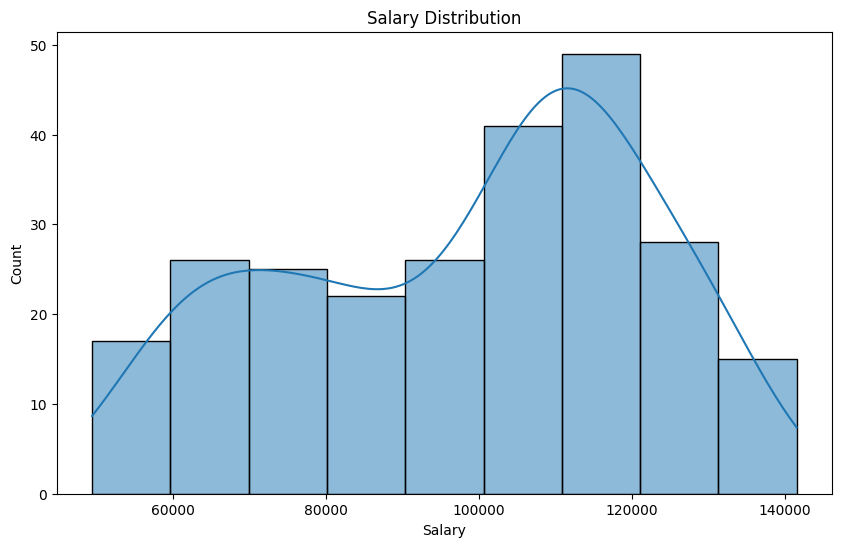

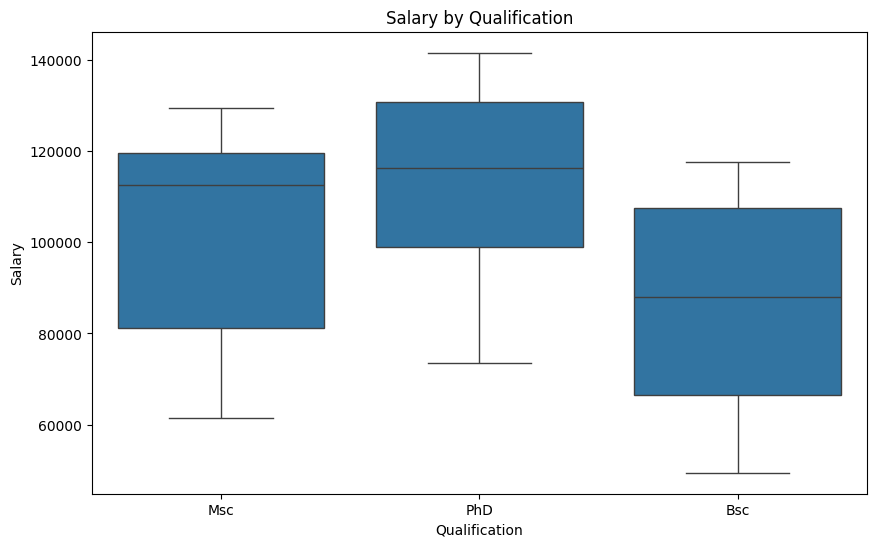

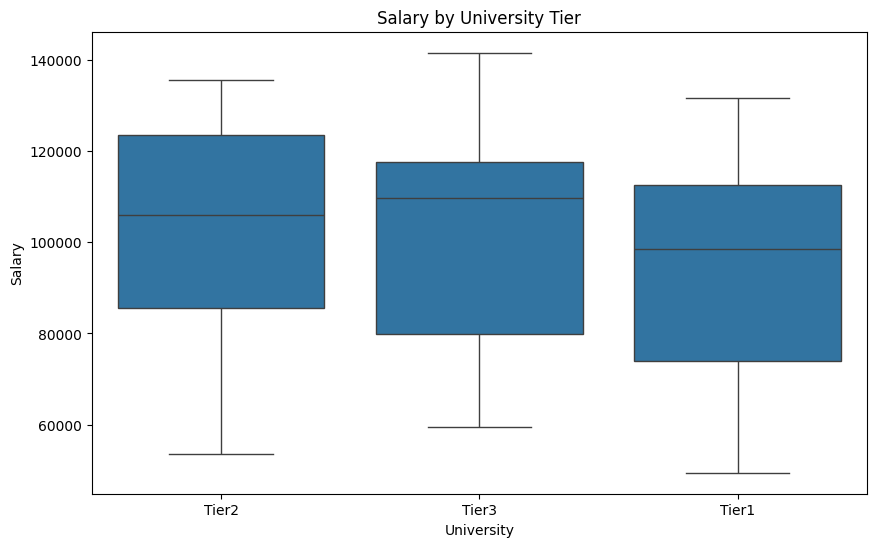

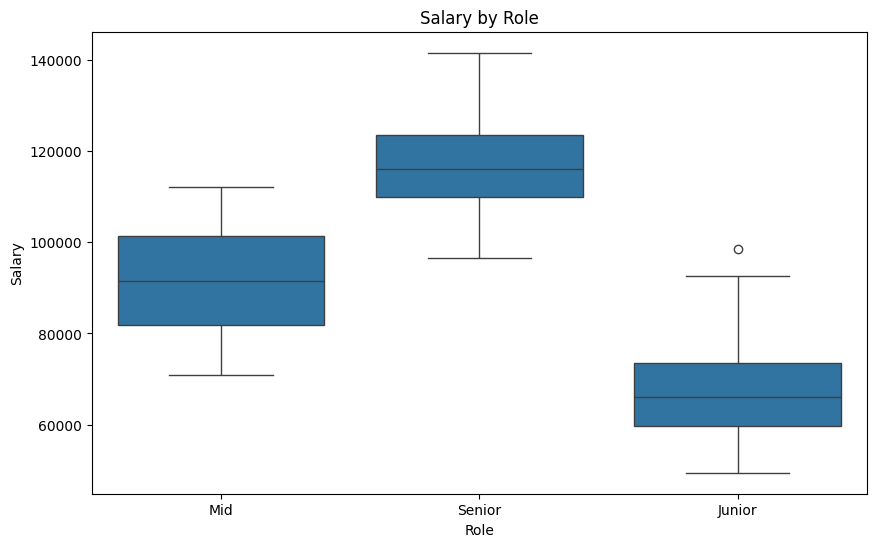

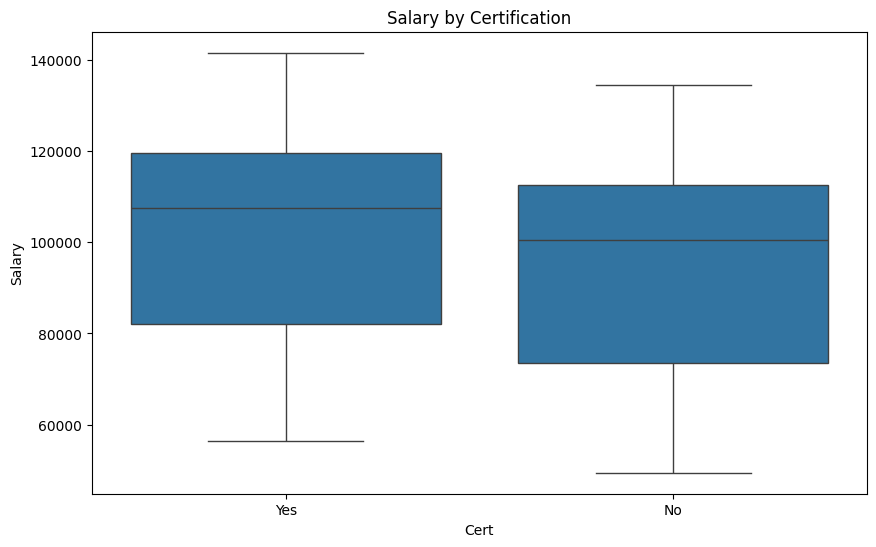

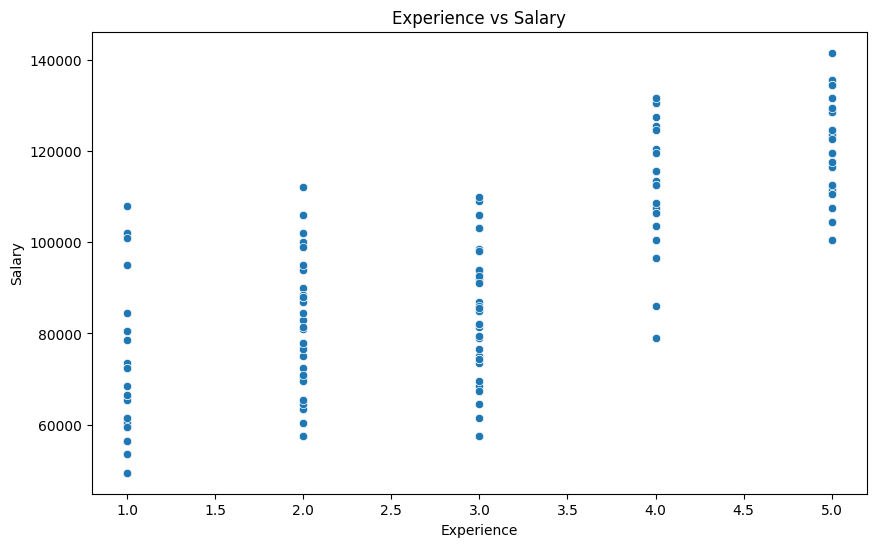

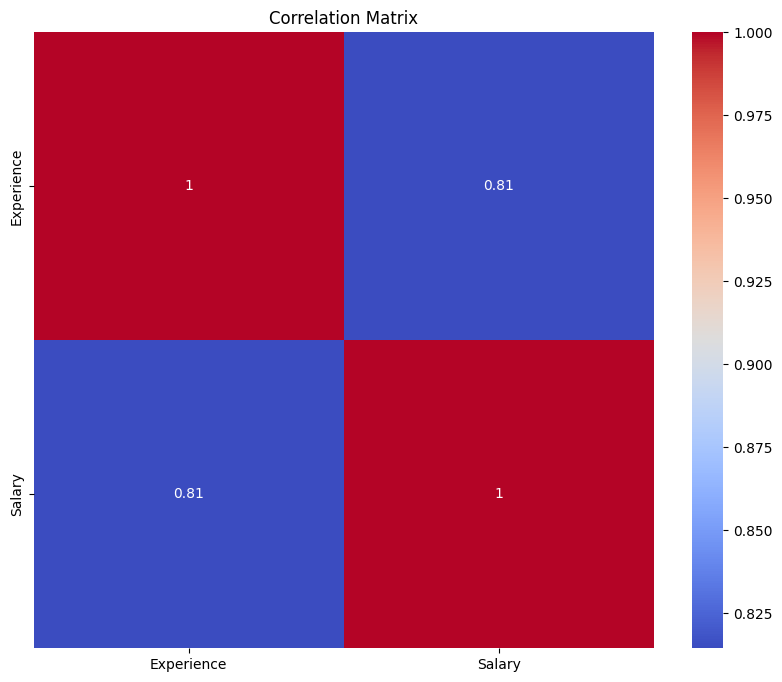

In [5]:
# Distribution of salary
plt.figure(figsize=(10, 6))
sns.histplot(train_data[TARGET], kde=True)
plt.title("Salary Distribution")
plt.show()

# Salary by qualification
plt.figure(figsize=(10, 6))
sns.boxplot(x="Qualification", y=TARGET, data=train_data)
plt.title("Salary by Qualification")
plt.show()

# Salary by university tier
plt.figure(figsize=(10, 6))
sns.boxplot(x="University", y=TARGET, data=train_data)
plt.title("Salary by University Tier")
plt.show()

# Salary by role
plt.figure(figsize=(10, 6))
sns.boxplot(x="Role", y=TARGET, data=train_data)
plt.title("Salary by Role")
plt.show()

# Salary by certification
plt.figure(figsize=(10, 6))
sns.boxplot(x="Cert", y=TARGET, data=train_data)
plt.title("Salary by Certification")
plt.show()

# Correlation between experience and salary
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Experience", y=TARGET, data=train_data)
plt.title("Experience vs Salary")
plt.show()

# Calculate correlation matrix for numerical features
corr_matrix = train_data.select_dtypes(include=["float64", "int64"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [6]:
display(train_data.head(2))
display(train_data.select_dtypes(include="object").nunique())
display(train_data.skew(numeric_only=True))

,Name,Phone_Number,Experience,Qualification,University,Role,Cert,Date_Of_Birth,Salary
0,Jennifer Hernandez,120-602-1220,3.0,Msc,Tier2,Mid,Yes,25/08/1972,98000
1,Timothy Walker,840-675-8650,5.0,PhD,Tier2,Senior,Yes,03/12/2013,135500


Name             248
Phone_Number     249
Qualification      3
University         3
Role               3
Cert               2
Date_Of_Birth    247
dtype: int64

Experience   -0.388337
Salary       -0.343899
dtype: float64

Виходячи з результатів EDA, маємо наступне:
- Потрібно зрозуміти як обробити відсутні значення у `Experience`, `Qualification` та `Role`.
- Ознаку `Date_Of_Birth` можемо перетворити на вік - ознака `Age`.
- Також можемо припустити, що на зарплату не впливають такі ознаки як: `Phone_Number`, `Name`

In [7]:
def calculate_age(date_string):
    try:
        # 25/08/1972
        date_obj = datetime.datetime.strptime(date_string, "%d/%m/%Y")
        current_date = datetime.datetime.now()
        age = current_date.year - date_obj.year
        if current_date.month < date_obj.month or (
            current_date.month == date_obj.month and current_date.day < date_obj.day
        ):
            age -= 1
        return age
    except:
        return np.nan
# Test the function
display(train_data["Date_Of_Birth"].head(2))
display(train_data["Date_Of_Birth"].head(2).apply(calculate_age))

0    25/08/1972
1    03/12/2013
Name: Date_Of_Birth, dtype: object

0    52
1    11
Name: Date_Of_Birth, dtype: int64

In [ ]:
def preprocess_data(df, is_training=True):
    data = df.copy()

    # Extract age from Date_Of_Birth
    data["Age"] = data["Date_Of_Birth"].apply(calculate_age)

    # Drop unnecessary columns
    data = data.drop(["Name", "Phone_Number", "Date_Of_Birth"], axis=1)

    # Handle missing values
    if is_training:
        # For Experience, try to fill with median
        data["Experience"] = pd.to_numeric(data["Experience"], errors="coerce")
        data["Experience"] = data["Experience"].fillna(data["Experience"].median())

        # For Qualification, fill with most frequent value
        data["Qualification"] = data["Qualification"].fillna(
            data["Qualification"].mode()[0]
        )

        # For Role, fill with most frequent value
        data["Role"] = data["Role"].fillna(data["Role"].mode()[0])

        # Cert missing values
        data["Cert"] = data["Cert"].fillna("No")

        # Save these values for validation set
        global median_experience, mode_qualification, mode_role
        median_experience = data["Experience"].median()
        mode_qualification = data["Qualification"].mode()[0]
        mode_role = data["Role"].mode()[0]
    else:
        data["Experience"] = pd.to_numeric(data["Experience"], errors="coerce")
        data["Experience"] = data["Experience"].fillna(median_experience)
        data["Qualification"] = data["Qualification"].fillna(mode_qualification)
        data["Role"] = data["Role"].fillna(mode_role)
        data["Cert"] = data["Cert"].fillna("No")

    return data

# Preprocess training data
processed_train = preprocess_data(train_data, is_training=True)
processed_valid = preprocess_data(valid_data, is_training=False)

numerical_features = processed_train.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
categorical_features = processed_train.select_dtypes(
    include=["object"]
).columns.tolist()

print("Числові ознаки:", numerical_features)
print("Категоріальні ознаки:", categorical_features)

print("\nProcessed training data shape:", processed_train.shape)
print("Missing values after preprocessing:")
display(processed_train.isnull().sum())

print("\nSummary statistics of numerical features:")
display(processed_train[numerical_features].describe())

Числові ознаки: ['Experience', 'Salary', 'Age']
Категоріальні ознаки: ['Qualification', 'University', 'Role', 'Cert']

Processed training data shape: (249, 7)
Missing values after preprocessing:


Experience       0
Qualification    0
University       0
Role             0
Cert             0
Salary           0
Age              0
dtype: int64


Summary statistics of numerical features:


,Experience,Salary,Age
count,249.000000,249.000000,249.000000
mean,3.445783,98186.746988,36.080321
std,1.491262,23502.622217,11.994016
min,1.000000,49500.000000,3.000000
25%,2.000000,78500.000000,28.000000
50%,4.000000,104500.000000,37.000000
75%,5.000000,116500.000000,47.000000
max,5.000000,141500.000000,55.000000


In [9]:
display(processed_train.head())
display(processed_valid.head())

,Experience,Qualification,University,Role,Cert,Salary,Age
0,3.0,Msc,Tier2,Mid,Yes,98000,52
1,5.0,PhD,Tier2,Senior,Yes,135500,11
2,5.0,Msc,Tier2,Senior,Yes,123500,22
3,3.0,Bsc,Tier3,Mid,No,85000,55
4,5.0,Bsc,Tier2,Senior,Yes,111500,55


,Experience,Qualification,University,Role,Cert,Salary,Age
0,7,Bsc,Tier1,Senior,No,109300,46
1,2,Msc,Tier1,Mid,Yes,84800,32
2,3,Bsc,Tier3,Mid,Yes,98900,37
3,5,Msc,Tier2,Senior,No,116500,35
4,3,PhD,Tier1,Junior,Yes,75800,45


### Графіки після обробки

In [10]:
print("Числові ознаки:", numerical_features)
print("Категоріальні ознаки:", categorical_features)

Числові ознаки: ['Experience', 'Salary', 'Age']
Категоріальні ознаки: ['Qualification', 'University', 'Role', 'Cert']


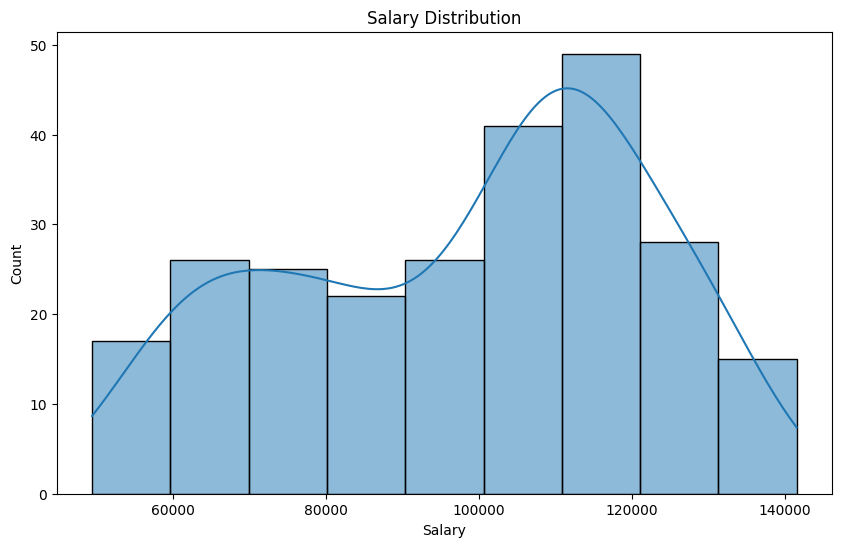

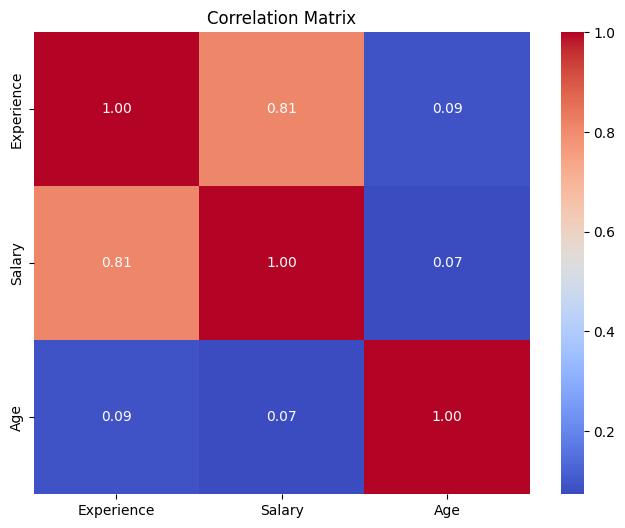

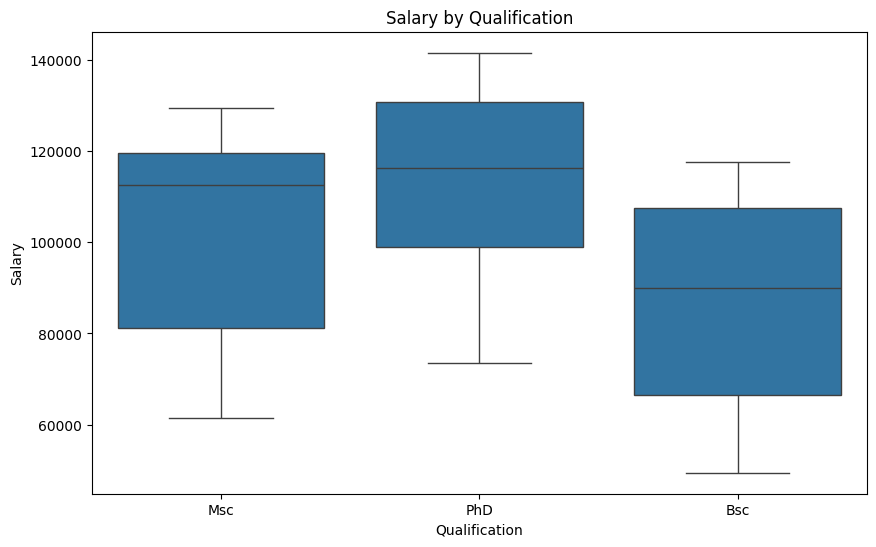

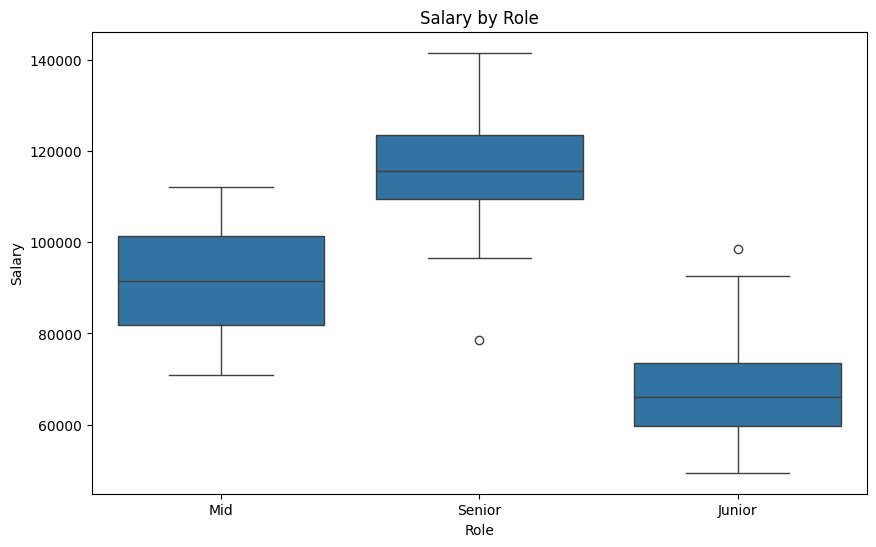

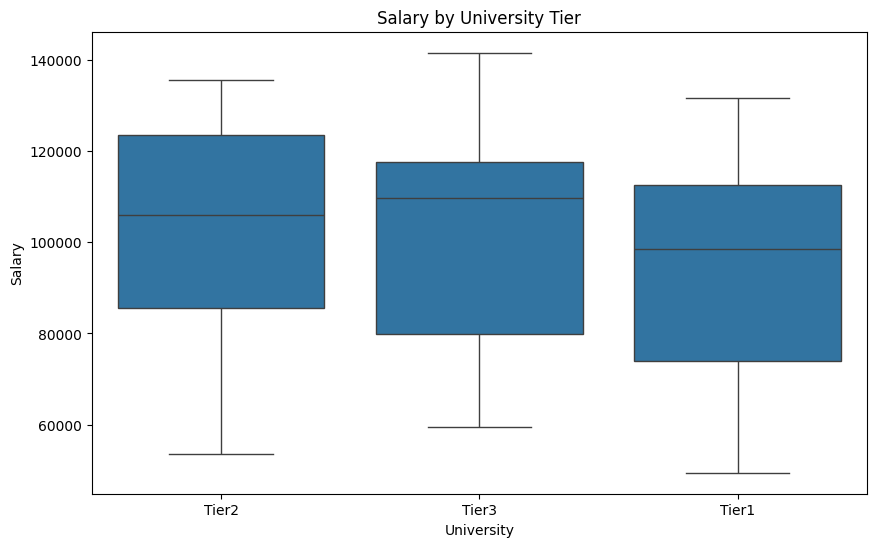

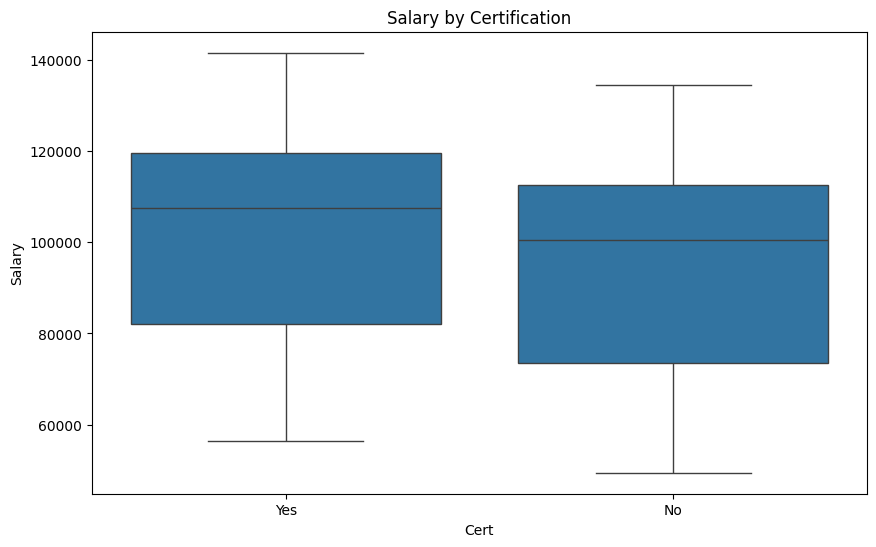

In [11]:
# Exploratory visualizations
plt.figure(figsize=(10, 6))
sns.histplot(processed_train[TARGET], kde=True)
plt.title("Salary Distribution")
plt.show()

# Correlation heatmap
corr = processed_train[numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Salary by qualifications
plt.figure(figsize=(10, 6))
sns.boxplot(x="Qualification", y=TARGET, data=processed_train)
plt.title("Salary by Qualification")
plt.show()

# Salary by role
plt.figure(figsize=(10, 6))
sns.boxplot(x="Role", y=TARGET, data=processed_train)
plt.title("Salary by Role")
plt.show()

# Salary by university tier
plt.figure(figsize=(10, 6))
sns.boxplot(x="University", y=TARGET, data=processed_train)
plt.title("Salary by University Tier")
plt.show()

# Salary by certification
plt.figure(figsize=(10, 6))
sns.boxplot(x="Cert", y=TARGET, data=processed_train)
plt.title("Salary by Certification")
plt.show()

## 3. Підготовка даних

### Визначимо ознаки та цільову змінну

In [12]:
X_train = processed_train.drop(TARGET, axis=1)
y_train = processed_train[TARGET]

X_valid = processed_valid.drop(TARGET, axis=1)
y_valid = processed_valid[TARGET]


numerical_features = X_train.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
categorical_features = X_train.select_dtypes(include=["object"]).columns.tolist()

print("Числові ознаки:", numerical_features)
print("Категоріальні ознаки:", categorical_features)

Числові ознаки: ['Experience', 'Age']
Категоріальні ознаки: ['Qualification', 'University', 'Role', 'Cert']


 ### Обробка числових ознак

In [13]:
experiment_results = []

def log_experiment(model_name, mape, rmse, r2):
    experiment_results.append(
        {"Model": model_name, "MAPE": mape, "RMSE": rmse, "R²": r2}
    )

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        (
            "cat",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            categorical_features,
        ),
    ]
)

knn_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor(n_neighbors=7, weights="distance", p=2)),
    ]
)


knn_pipeline.fit(X_train, y_train)
# Make predictions on validation data
y_pred = knn_pipeline.predict(X_valid)

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

log_experiment("Basic KNN", mape, rmse, r2)

## Експерименти

In [15]:
# Experiment 1: Using other models (RandomForest and GradientBoosting)
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=100, random_state=42)),
    ]
)
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_valid)
log_experiment(
    "RandomForestRegressor",
    mean_absolute_percentage_error(y_valid, y_pred_rf),
    np.sqrt(mean_squared_error(y_valid, y_pred_rf)),
    r2_score(y_valid, y_pred_rf),
)

gb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ]
)
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_valid)
log_experiment(
    "GradientBoostingRegressor",
    mean_absolute_percentage_error(y_valid, y_pred_gb),
    np.sqrt(mean_squared_error(y_valid, y_pred_gb)),
    r2_score(y_valid, y_pred_gb),
)

# Experiment 2: Logarithmic transformation of target variable
y_train_log = np.log(y_train)
y_valid_log = np.log(y_valid)

knn_log_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor(n_neighbors=7, weights="distance", p=2)),
    ]
)
knn_log_pipeline.fit(X_train, y_train_log)
y_pred_knn_log = np.exp(knn_log_pipeline.predict(X_valid))
log_experiment(
    "KNN with Log Salary",
    mean_absolute_percentage_error(y_valid, y_pred_knn_log),
    np.sqrt(mean_squared_error(y_valid, y_pred_knn_log)),
    r2_score(y_valid, y_pred_knn_log),
)

# Experiment 3: KNN hyperparameter optimization
param_grid_knn = {
    "regressor__n_neighbors": [5, 7, 9, 11],
    "regressor__weights": ["uniform", "distance"],
    "regressor__p": [1, 2],
}
knn_grid_search = GridSearchCV(
    knn_pipeline,
    param_grid_knn,
    cv=5,
    scoring="neg_mean_absolute_percentage_error",
    verbose=1,
)
knn_grid_search.fit(X_train, y_train)
y_pred_knn_opt = knn_grid_search.best_estimator_.predict(X_valid)
log_experiment(
    "Optimized KNN",
    mean_absolute_percentage_error(y_valid, y_pred_knn_opt),
    np.sqrt(mean_squared_error(y_valid, y_pred_knn_opt)),
    r2_score(y_valid, y_pred_knn_opt),
)

experiment_results_df = pd.DataFrame(experiment_results)
display(experiment_results_df)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,Model,MAPE,RMSE,R²
0,Basic KNN,0.083216,9926.815048,0.610789
1,RandomForestRegressor,0.114724,11691.967939,0.460066
2,GradientBoostingRegressor,0.107773,10886.094363,0.531931
3,KNN with Log Salary,0.078648,9650.634228,0.632144
4,Optimized KNN,0.102404,11819.752706,0.448199


### Візуалізація

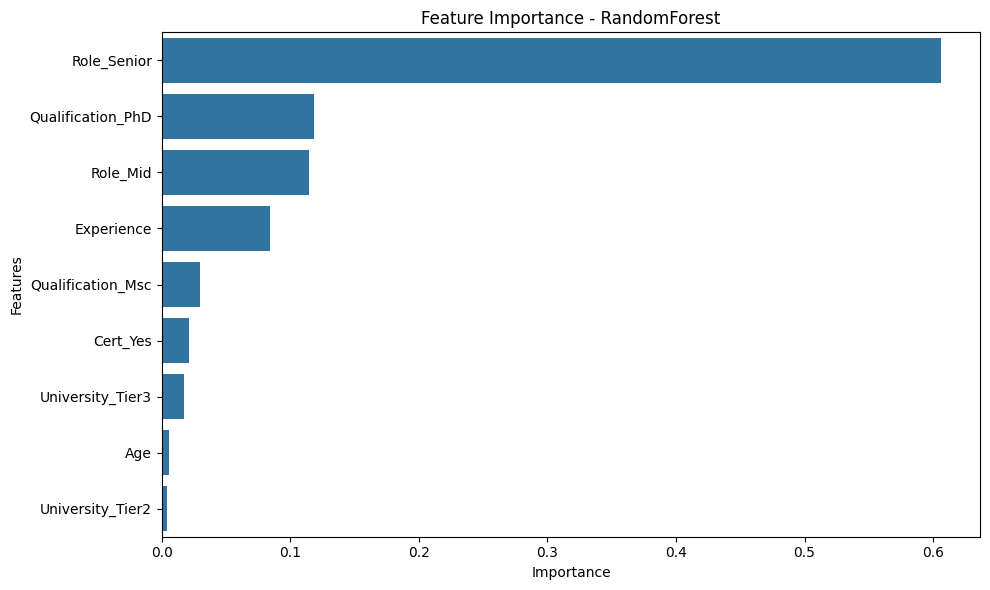

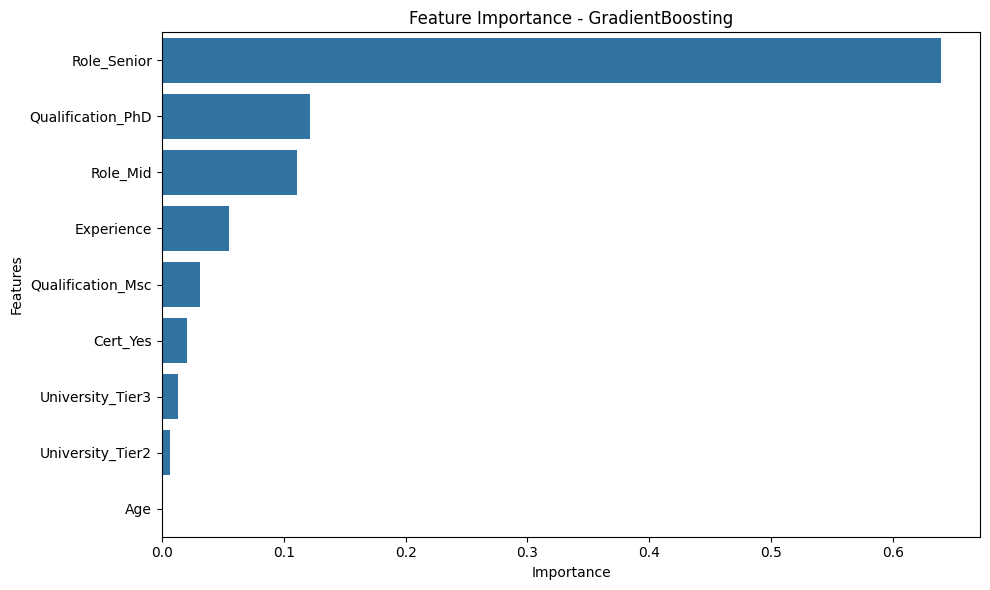

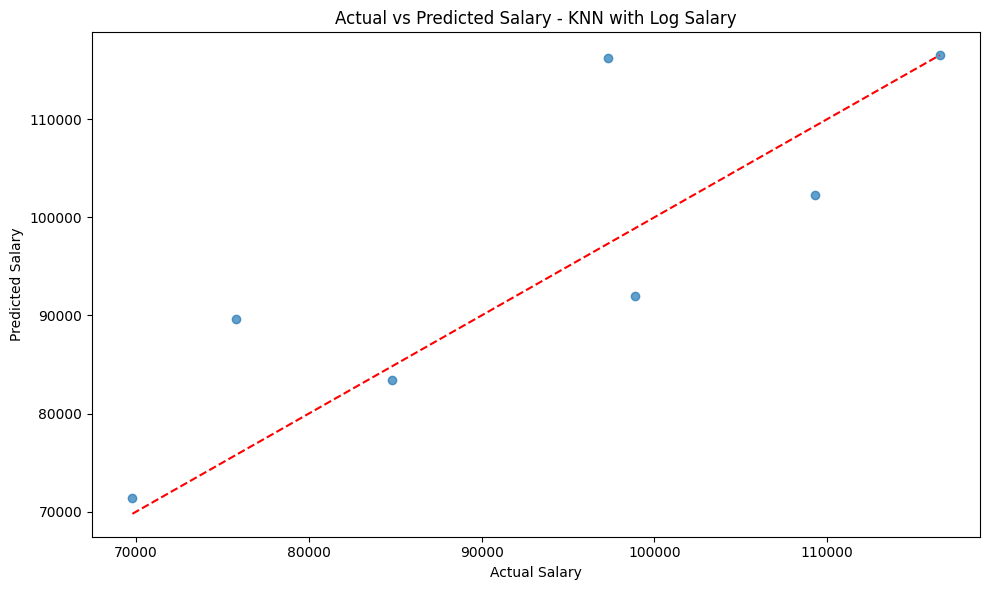

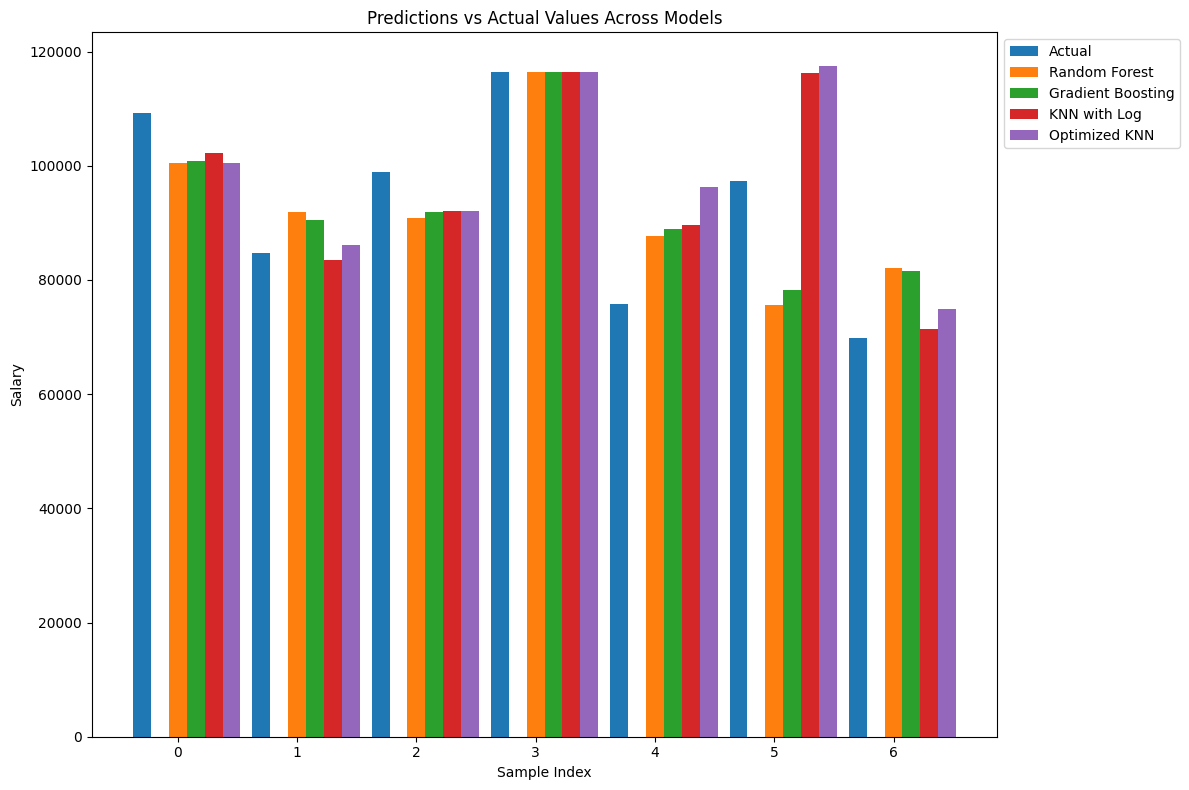

In [16]:
importances_rf = rf_pipeline.named_steps["regressor"].feature_importances_
importances_gb = gb_pipeline.named_steps["regressor"].feature_importances_

encoded_feature_names = list(
    preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
)
all_feature_names = numerical_features + encoded_feature_names

rf_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances_rf
}).sort_values("Importance", ascending=False)

gb_importance_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances_gb
}).sort_values("Importance", ascending=False)

# Plot feature importance for RandomForest
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=rf_importance_df)
plt.title("Feature Importance - RandomForest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Plot feature importance for GradientBoosting
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=gb_importance_df)
plt.title("Feature Importance - GradientBoosting")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted Salary for the best model (KNN with log transformation)
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_knn_log, alpha=0.7)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], "r--")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary - KNN with Log Salary")
plt.tight_layout()
plt.show()

# Plot all models' predictions vs actual values
plt.figure(figsize=(12, 8))
models = {
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb,
    "KNN with Log": y_pred_knn_log,
    "Optimized KNN": y_pred_knn_opt
}

x = np.arange(len(y_valid))
width = 0.15
multiplier = 0

# Plot bar chart comparing predictions from different models
plt.bar(x - 0.3, y_valid, width, label='Actual')
for model_name, predictions in models.items():
    offset = width * multiplier
    plt.bar(x + offset, predictions, width, label=model_name)
    multiplier += 1

plt.xlabel('Sample Index')
plt.ylabel('Salary')
plt.title('Predictions vs Actual Values Across Models')
plt.xticks(x)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

## Висновки

1. Вплив ознаки `AGE` на точність моделей:
    - Додавання `AGE` покращує `KNN with Log Salary`, але погіршує `Optimized KNN`.
    - `MAPE` у `Optimized KNN` без `AGE` зменшився (10.24% → 9.70%), а `R²` зріс (0.448 → 0.654).
    - `MAPE` у `KNN with Log Salary` без `AGE` погіршився (7.86% → 10.77%), що вказує на важливість ознаки для цієї моделі.

2. Порівняння моделей:
    - `GradientBoostingRegressor` показує кращий `R²` без `AGE` (0.556 vs 0.532), отже, він менш залежний від цієї ознаки.
    - `RandomForestRegressor` також показує трохи кращі результати без `AGE` (0.495 vs 0.460).
    - `Optimized KNN` без `AGE` є найкращою моделлю (`R²` = 0.654), що означає, що ця модель краща без цієї ознаки.
3. Спостереження:
    - Якщо використовувати `KNN with Log Salary`, то `AGE` важливий.
    - Якщо обирати `Optimized KNN`, краще виключити `AGE`.
    - `GradientBoostingRegressor` залишається стабільним незалежно від `AGE`.
    - `RandomForest` показує незначне покращення без `AGE`, але залишається менш ефективним за `GB` та `KNN`.
    - `Optimized KNN` без `AGE` є найкращим варіантом (найнижчий `RMSE` та найвищий `R²`).